In [1]:
import scipy
import sys
import pandas
import numpy
import matplotlib.pyplot as plt
import numpy as np
import curvefit

In [14]:
# f(t, alpha, beta, p)
def generalized_logistic(t, params) :
    alpha = params[0]
    beta  = params[1]
    p     = params[2]
    return p / ( 1.0 + numpy.exp( - alpha * ( t - beta ) ) )
#
# identity function
def identity_fun(x) :
    return x
#
# link function used for alpha, p
def exp_fun(x) :
    return numpy.exp(x)
#
# inverse of function used for alpha, p
def log_fun(x) :
    return numpy.log(x)

dataset = pandas.read_csv('dataset_for_CurveFit_updated.csv')
dataset = dataset.drop(['Date', 'Unnamed: 0'], axis=1)
state_len = {}

for state in dataset.State.unique():
    state_len[state] = {'population': max(dataset[dataset["State"] == state]["StatePopulation"])/1000000, 'days': len(dataset[dataset["State"] == state]["DateI"]), 'confirmed_high': max(dataset[dataset["State"] == state]["Confirmed"])}
    #dataset.loc[dataset["State"] == state, "Confirmed"]=numpy.log(dataset[dataset["State"] == state]["Confirmed"]/state_len[state]['confirmed_high'])
    dataset.loc[dataset["State"] == state, "DateI"] = dataset[dataset["State"] == state]["DateI"]

n_data = dataset.shape[0]
dataset["constant_one"] = n_data * [1.0]
dataset["SE"] = n_data * [0.1]

In [15]:
dataset_UP = dataset[dataset['State'] == "Uttar Pradesh"]

In [16]:
num_params   = 3
num_fe       = 3
beta_true    = 20.0             
alpha_true   = 2.0 / beta_true  
p_true       = 0.1  
params_true = numpy.array( [ alpha_true, beta_true, p_true ] )
# curve_model
col_t        = 'DateI'
col_obs      = 'Confirmed'
col_covs     = num_params *[ [ 'DaysCovariate' ] ]
col_group    = 'State'
param_names  = [ 'alpha', 'beta',       'p'     ]
link_fun     = [ exp_fun, identity_fun, exp_fun ]
var_link_fun = num_fe * [ identity_fun ]
fun          = generalized_logistic
col_obs_se   = 'SE'

curve_model = curvefit.core.model.CurveModel(
    dataset_UP,
    col_t,
    col_obs,
    col_covs,
    col_group,
    param_names,
    link_fun,
    var_link_fun,
    fun,
    col_obs_se
)

In [17]:
inv_link_fun = [ log_fun, identity_fun, log_fun ]
fe_init      = numpy.zeros( num_fe )
for i in range(num_fe) :
    fe_init[i]   = inv_link_fun[i](params_true[i]) / 3.0

re_init   = numpy.zeros( num_fe )
fe_bounds = [ [-numpy.inf, numpy.inf] ] * num_fe
re_bounds = [ [0.0, 0.0] ] * num_fe
options={
    'ftol' : 1e-12,
    'gtol' : 1e-12,
}
#
curve_model.fit_params(
    fe_init,
    re_init,
    fe_bounds,
    re_bounds,
    options=options
)

params_estimate = curve_model.params

In [18]:
curve_model.params

array([[ 1.07548187],
       [13.27381599],
       [ 0.77343462]])

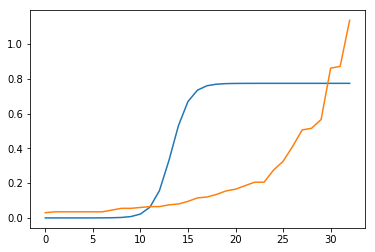

In [19]:
x = dataset[dataset['State'] == "Uttar Pradesh"]['DateI']
y_curve = generalized_logistic(x, curve_model.params)
y_actual = dataset[dataset['State'] == "Uttar Pradesh"]['Confirmed']
plt.plot(x, y_curve)
plt.plot(x, y_actual)